In [27]:
import os
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import yaml
import numpy as np
import random
import seaborn as sns

from sklearn.manifold import TSNE
from models.VQ_VAE import VQVAE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [48]:
def check_same_label():
    global global_image_features
    
    keys = list(global_image_features.keys())
    keys.sort()
    
    previous_label = global_image_features[keys[0]]['label']
    for name in keys[1:]:
        current_label = global_image_features[name]['label']
        if not np.all(previous_label == current_label):
            print(f'{name} and {keys[0]} have different labels')
            raise ValueError('The labels of different models are not the same')


def get_model(model_configs, save_dir):
    use_vq = model_configs['use_vq']
    if 'projection_dim' in model_configs:
        use_compressed = True
        projection_dim = model_configs['projection_dim']
    else:
        use_compressed = False
        projection_dim = 32
    model = VQVAE(model_configs['vq_params'], model_configs['backbone_configs'], use_vq=use_vq, init_size=0, use_compressed=use_compressed, projection_dim=projection_dim)
    print(f'loading path: {os.path.join(save_dir, 'model.pth')}')
    model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth')))

    return model
    
    
def compute_cosine_similarity(data_ori, data_recon):
    # Normalize the vectors
    data_ori_norm = data_ori / np.linalg.norm(data_ori, axis=1)[:, np.newaxis]
    data_recon_norm = data_recon / np.linalg.norm(data_recon, axis=1)[:, np.newaxis]
    
    # Compute cosine similarity for each pair of vectors
    similarities = np.sum(data_ori_norm * data_recon_norm, axis=1)
    
    # Return the mean similarity
    return np.mean(similarities)
    

def compute_average_distance(data_ori, data_recon):
    distance = np.linalg.norm(data_ori - data_recon, axis=1)
    return np.mean(distance)
    

def visualize_data_seperate(global_image_features):
    visualize_size = 1000
    
    # sort the keys
    keys = list(global_image_features.keys())
    keys.sort()    
    
    selected_key = keys[0]
    decomposition_list = [global_image_features[selected_key]['input'][:visualize_size]]
    label = global_image_features[selected_key]['label'][:visualize_size]
    
    for name in keys:
        decomposition_list.append(global_image_features[name]['recon'][:visualize_size])
        
    
    data_concat = np.concatenate(decomposition_list, axis=0)
    
    seperate_decompose = {}
    for i, name in enumerate(keys):
        if name != 'original':
            begin = visualize_size * (i + 1)
            end = visualize_size * (i + 2)
            
            data_ori_pair = [data_concat[0:visualize_size], data_concat[begin:end]]
            data_ori_pair = np.concatenate(data_ori_pair, axis=0)
            seperate_decompose[name] = data_ori_pair
            
    
    subplots_H = 4
    subplots_L = len(keys) // subplots_H
    print(f'subplots_H: {subplots_H}, subplots_L: {subplots_L}')
    print(len(keys))
    
    # Plot 2D
    _, axs = plt.subplots(subplots_H, subplots_L, figsize=(6 * subplots_L, 6 * subplots_H))
    
    for i, name in enumerate(keys):
        data = seperate_decompose[name]
        ax = axs[i // subplots_L, i % subplots_L]
        model_name = name.split(':')[0]
        
        # compute cosine similarity and average distance
        cosine_similarity_before_decomposing = compute_cosine_similarity(data[0:visualize_size], data[visualize_size:])
        distance_before_decomposing = compute_average_distance(data[0:visualize_size], data[visualize_size:])
        
        # standardize the data
        data_std = StandardScaler().fit_transform(data)
        
        # pca decomposition
        pca = PCA(n_components=128)
        data_pca = pca.fit_transform(data_std)
        
        # tsne decomposition
        tsne = TSNE(n_components=2, random_state=42)
        data_tsne = tsne.fit_transform(data_pca)
        
        data_recon = data_tsne[visualize_size:]
        data_ori = data_tsne[0:visualize_size]
        
        for i in range(10):
            index = np.where(label == i)[0]
            data_ori_i = data_ori[index]
            data_recon_i = data_recon[index]
            
            
            
            
            # sns.stripplot(x=data_ori_i[:50, 0], y=data_ori_i[:50, 1], 
            #              color='cyan', alpha=0.3, ax=ax)
            ax.scatter(data_ori_i[:50, 0], data_ori_i[:50, 1], c='cyan', alpha=0.3)
            
            # sns.stripplot(x=data_recon_i[:50, 0], y=data_recon_i[:50, 1], 
            #                color='red', alpha=0.3, ax=ax)
            ax.scatter(data_recon_i[:50, 0], data_recon_i[:50, 1], c='red', alpha=0.3)
            
            ax.set_title(model_name, fontsize=8)
            
            # add the cosine similarity
            ax.text(0.05, 0.95, f'Cos Sim: {cosine_similarity_before_decomposing:.4f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
            ax.text(0.05, 0.75, f'Avg Dist: {distance_before_decomposing:.4f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    plt.show()



def visualize_data_direct_decompose(global_image_flattened, jitter=0.1):
    # visualize the mean
    visualize_size = 1000
    # sort the keys
    keys = list(global_image_flattened.keys())
    keys.sort()    
    
    selected_key = keys[0]
    data_ori = global_image_flattened[selected_key]['input'][:visualize_size]
    decomposition_list = [data_ori]
    label = global_image_features[selected_key]['label'][:visualize_size]
    
    cosine_similarity_list = []
    distance_list = []
    for name in keys:
        recon_data = global_image_flattened[name]['recon'][:visualize_size]
        decomposition_list.append(recon_data)
        
        cosine_similarity = compute_cosine_similarity(data_ori, recon_data)
        distance = compute_average_distance(data_ori, recon_data)
        
        cosine_similarity_list.append(cosine_similarity)
        distance_list.append(distance)
        
        
    data_concat = np.concatenate(decomposition_list, axis=0)
    
    # t-SNE decomposition
    print('begin to decompose the data 2d')
    tsne_dim_2 = TSNE(n_components=2, random_state=42)
    data_concat_tsne_dim_2 = tsne_dim_2.fit_transform(data_concat)
    
    # Plot 2D t-SNE visualization
    subplots_H = 4
    subplots_L = len(keys) // subplots_H
    _, axs = plt.subplots(subplots_H, subplots_L, figsize=(6 * subplots_L, 6 * subplots_H))
    ori_data = data_concat_tsne_dim_2[0:visualize_size]
    for i, name in enumerate(keys):
        if name != 'original':
            # get the subplot
            ax = axs[i // subplots_L, i % subplots_L]
            model_name = name.split(':')[0]
            begin = visualize_size * (i + 1)
            end = visualize_size * (i + 2)
            
            # get the corresponding data
            plot_data = data_concat_tsne_dim_2[begin:end]
            
            for j in range(10):
                index = np.where(label == j)[0]
                plot_data_j = plot_data[index]
                
                sns.stripplot(x=plot_data_j[:50, 0], y=plot_data_j[:50, 1], c='red', alpha=0.3, ax=ax, jitter=True)
                sns.stripplot(x=ori_data[index][:50, 0], y=ori_data[index][:50, 1], c='cyan', alpha=0.3, ax=ax, jitter=True)
                # ax.scatter(plot_data_j[:50, 0], plot_data_j[:50, 1], c='red', alpha=0.3)
                # ax.scatter(ori_data[index][:50, 0], ori_data[index][:50, 1], c='cyan', alpha=0.3)
        
            ax.text(0.05, 0.95, f'Cos Sim: {cosine_similarity_list[i]:.4f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
            ax.text(0.05, 0.75, f'Avg Dist: {distance_list[i]:.4f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
            ax.set_title(model_name)
    plt.show()

        
    
def test_model(model, test_loader, name, device, n_embeddings, resnet_model):
    model.eval()

    cum_perplexity = 0
    cum_mse = 0.0
    cum_usage = 0.0

    embedding_num = n_embeddings
    global global_image_features, global_image_flattened
    
    recon_flatten_list = []
    input_flatten_list = []
    
    input_features_list = []
    recon_features_list = []
    label_list = []
    
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(test_loader):
            input, target = input.to(device), target.to(device)
            recon, _, indices, perplexity, _, _ = model(input)
            if model.use_vq:
                cum_perplexity += perplexity.cpu().item()
                usage = indices.unique().shape[0] / embedding_num
                cum_usage += usage
            cum_mse += F.mse_loss(recon, input).cpu().item()
            
            recon = recon.detach()
            
            # flatten the data
            recon_flatten = recon.reshape(recon.size(0), -1).cpu().numpy()
            input_flatten = input.reshape(input.size(0), -1).cpu().numpy()
            
            recon_flatten_list.append(recon_flatten)
            input_flatten_list.append(input_flatten)
            
            recon_features = resnet_model(recon)
            recon_features = recon_features.squeeze().cpu().numpy()
            
            input_features = resnet_model(input)
            input_features = input_features.squeeze().cpu().numpy()
            
            target = target.cpu().numpy()
            
            
            input_features_list.append(input_features)
            recon_features_list.append(recon_features)
            label_list.append(target)
        
        input_flatten_np = np.concatenate(input_flatten_list, axis=0)
        recon_flatten_np = np.concatenate(recon_flatten_list, axis=0)
        
        input_features_np = np.concatenate(input_features_list, axis=0)
        recon_features_np = np.concatenate(recon_features_list, axis=0)
        label_np = np.concatenate(label_list, axis=0)
        
        print(f'{name} has {recon_features_np.shape} samples')
        print(f'{name} has {input_features_np.shape} samples')
        print(f'{name} has {label_np.shape} samples')
            
        global_image_features[name] = {'recon': recon_features_np, 'input': input_features_np, 'label': label_np}
        global_image_flattened[name] = {'recon': recon_flatten_np, 'input': input_flatten_np, 'label': label_np}
    avg_perplexity = cum_perplexity / len(test_loader)
    avg_mse = cum_mse / len(test_loader)
    avg_usage = cum_usage / len(test_loader)

    print(f'{name} Perplexity: {avg_perplexity}, MSE: {avg_mse}, Usage: {avg_usage}')
    
    return avg_perplexity, avg_mse, avg_usage



In [35]:
config_root_path = '/data3/zwh/VQ_Selection_Real_Data/save_tight_bottleneck_vq'
configs = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

global_image_features = {}
global_image_flattened = {}

subdir_all_path = os.listdir(config_root_path)
seed = 4568

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.enable = False
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load classification model (which is used to extract features)
resnet = torchvision.models.resnet18(weights=None)

resnet.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet.maxpool = torch.nn.Identity()
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)

resnet = resnet.to(device)

model_state_dict = torch.load('/home/wenhao/VQ_Selection/pretrained_resnet/resnet18_cifar10.pth')
resnet.load_state_dict(model_state_dict)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

# load all configs
for config_path in subdir_all_path:
    path = os.path.join(config_root_path, config_path)
    for time_dir in os.listdir(path):
        model_path = os.path.join(path, time_dir, 'model.pth')
        if os.path.exists(model_path):
            file = os.path.join(path, time_dir, 'saved_config.yaml')
            with open(os.path.join(path, file), 'r') as f:
                config = yaml.load(f, Loader=yaml.FullLoader)
            configs.append(config)


transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
batch_size = 128
num_workers = 4

test_dataset = torchvision.datasets.CIFAR10(root='/data/zwh', train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


information = []
print("============================test begin================================")
for config in configs:
    model = get_model(config['model_configs'], config['train_configs']['save_dir'])
    n_embeddings = config['model_configs']['vq_params']['n_embeddings']
    model = model.to(device)
    
    path = config['train_configs']['save_dir']
    path = path.split('/')
    name = path[-2] + ':' + path[-1] 
    perplexity, mse, usage = test_model(model, test_loader, name, device, n_embeddings, resnet)
    information.append((name, perplexity, mse, usage))
    print()
    print()



for name, perplexity, mse, usage in information:
    print(f'{name} Perplexity: {perplexity}, MSE: {mse}, Usage: {usage}')

/tmp/ipykernel_272555/3713222443.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load('/home/wenhao/VQ_Selection/pretrained_resnet/resnet18_cif

============================test begin================================
Using custom conv configs: {'kernel': [4, 4, 4, 3], 'padding': [1, 1, 1, 1], 'res_kernel': 3, 'res_padding': 1, 'res_stride': 1, 'stride': [2, 2, 2, 1]}
Using custom kernel configs: [3, 4, 4, 4]
[4]
change pre conv size
Use compressed to project the latent space to lower dimension64
loading path: /data3/zwh/VQ_Selection_Real_Data/save_tight_bottleneck_vq/Cifar10_vq_512_4_4_64/2024-11-11_02-12-34/model.pth


/tmp/ipykernel_272555/1426276931.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth')))


Cifar10_vq_512_4_4_64:2024-11-11_02-12-34 has (10000, 512) samples
Cifar10_vq_512_4_4_64:2024-11-11_02-12-34 has (10000, 512) samples
Cifar10_vq_512_4_4_64:2024-11-11_02-12-34 has (10000,) samples
Cifar10_vq_512_4_4_64:2024-11-11_02-12-34 Perplexity: 387.03161196165445, MSE: 0.036657102971891814, Usage: 0.9237045094936709


Using custom conv configs: {'kernel': [4, 4, 4, 4, 4, 3], 'padding': [1, 1, 1, 1, 1, 1], 'res_kernel': 3, 'res_padding': 1, 'res_stride': 1, 'stride': [2, 2, 2, 2, 2, 1]}
Using custom kernel configs: [3, 4, 4, 4, 4, 4]
[4, 4, 4]
change pre conv size
Use compressed to project the latent space to lower dimension32
loading path: /data3/zwh/VQ_Selection_Real_Data/save_tight_bottleneck_vq/Cifar10_vq_512_1_1_64_32/2024-11-11_01-57-26/model.pth
Cifar10_vq_512_1_1_64_32:2024-11-11_01-57-26 has (10000, 512) samples
Cifar10_vq_512_1_1_64_32:2024-11-11_01-57-26 has (10000, 512) samples
Cifar10_vq_512_1_1_64_32:2024-11-11_01-57-26 has (10000,) samples
Cifar10_vq_512_1_1_64_32:2

In [36]:
check_same_label()

subplots_H: 4, subplots_L: 5
20


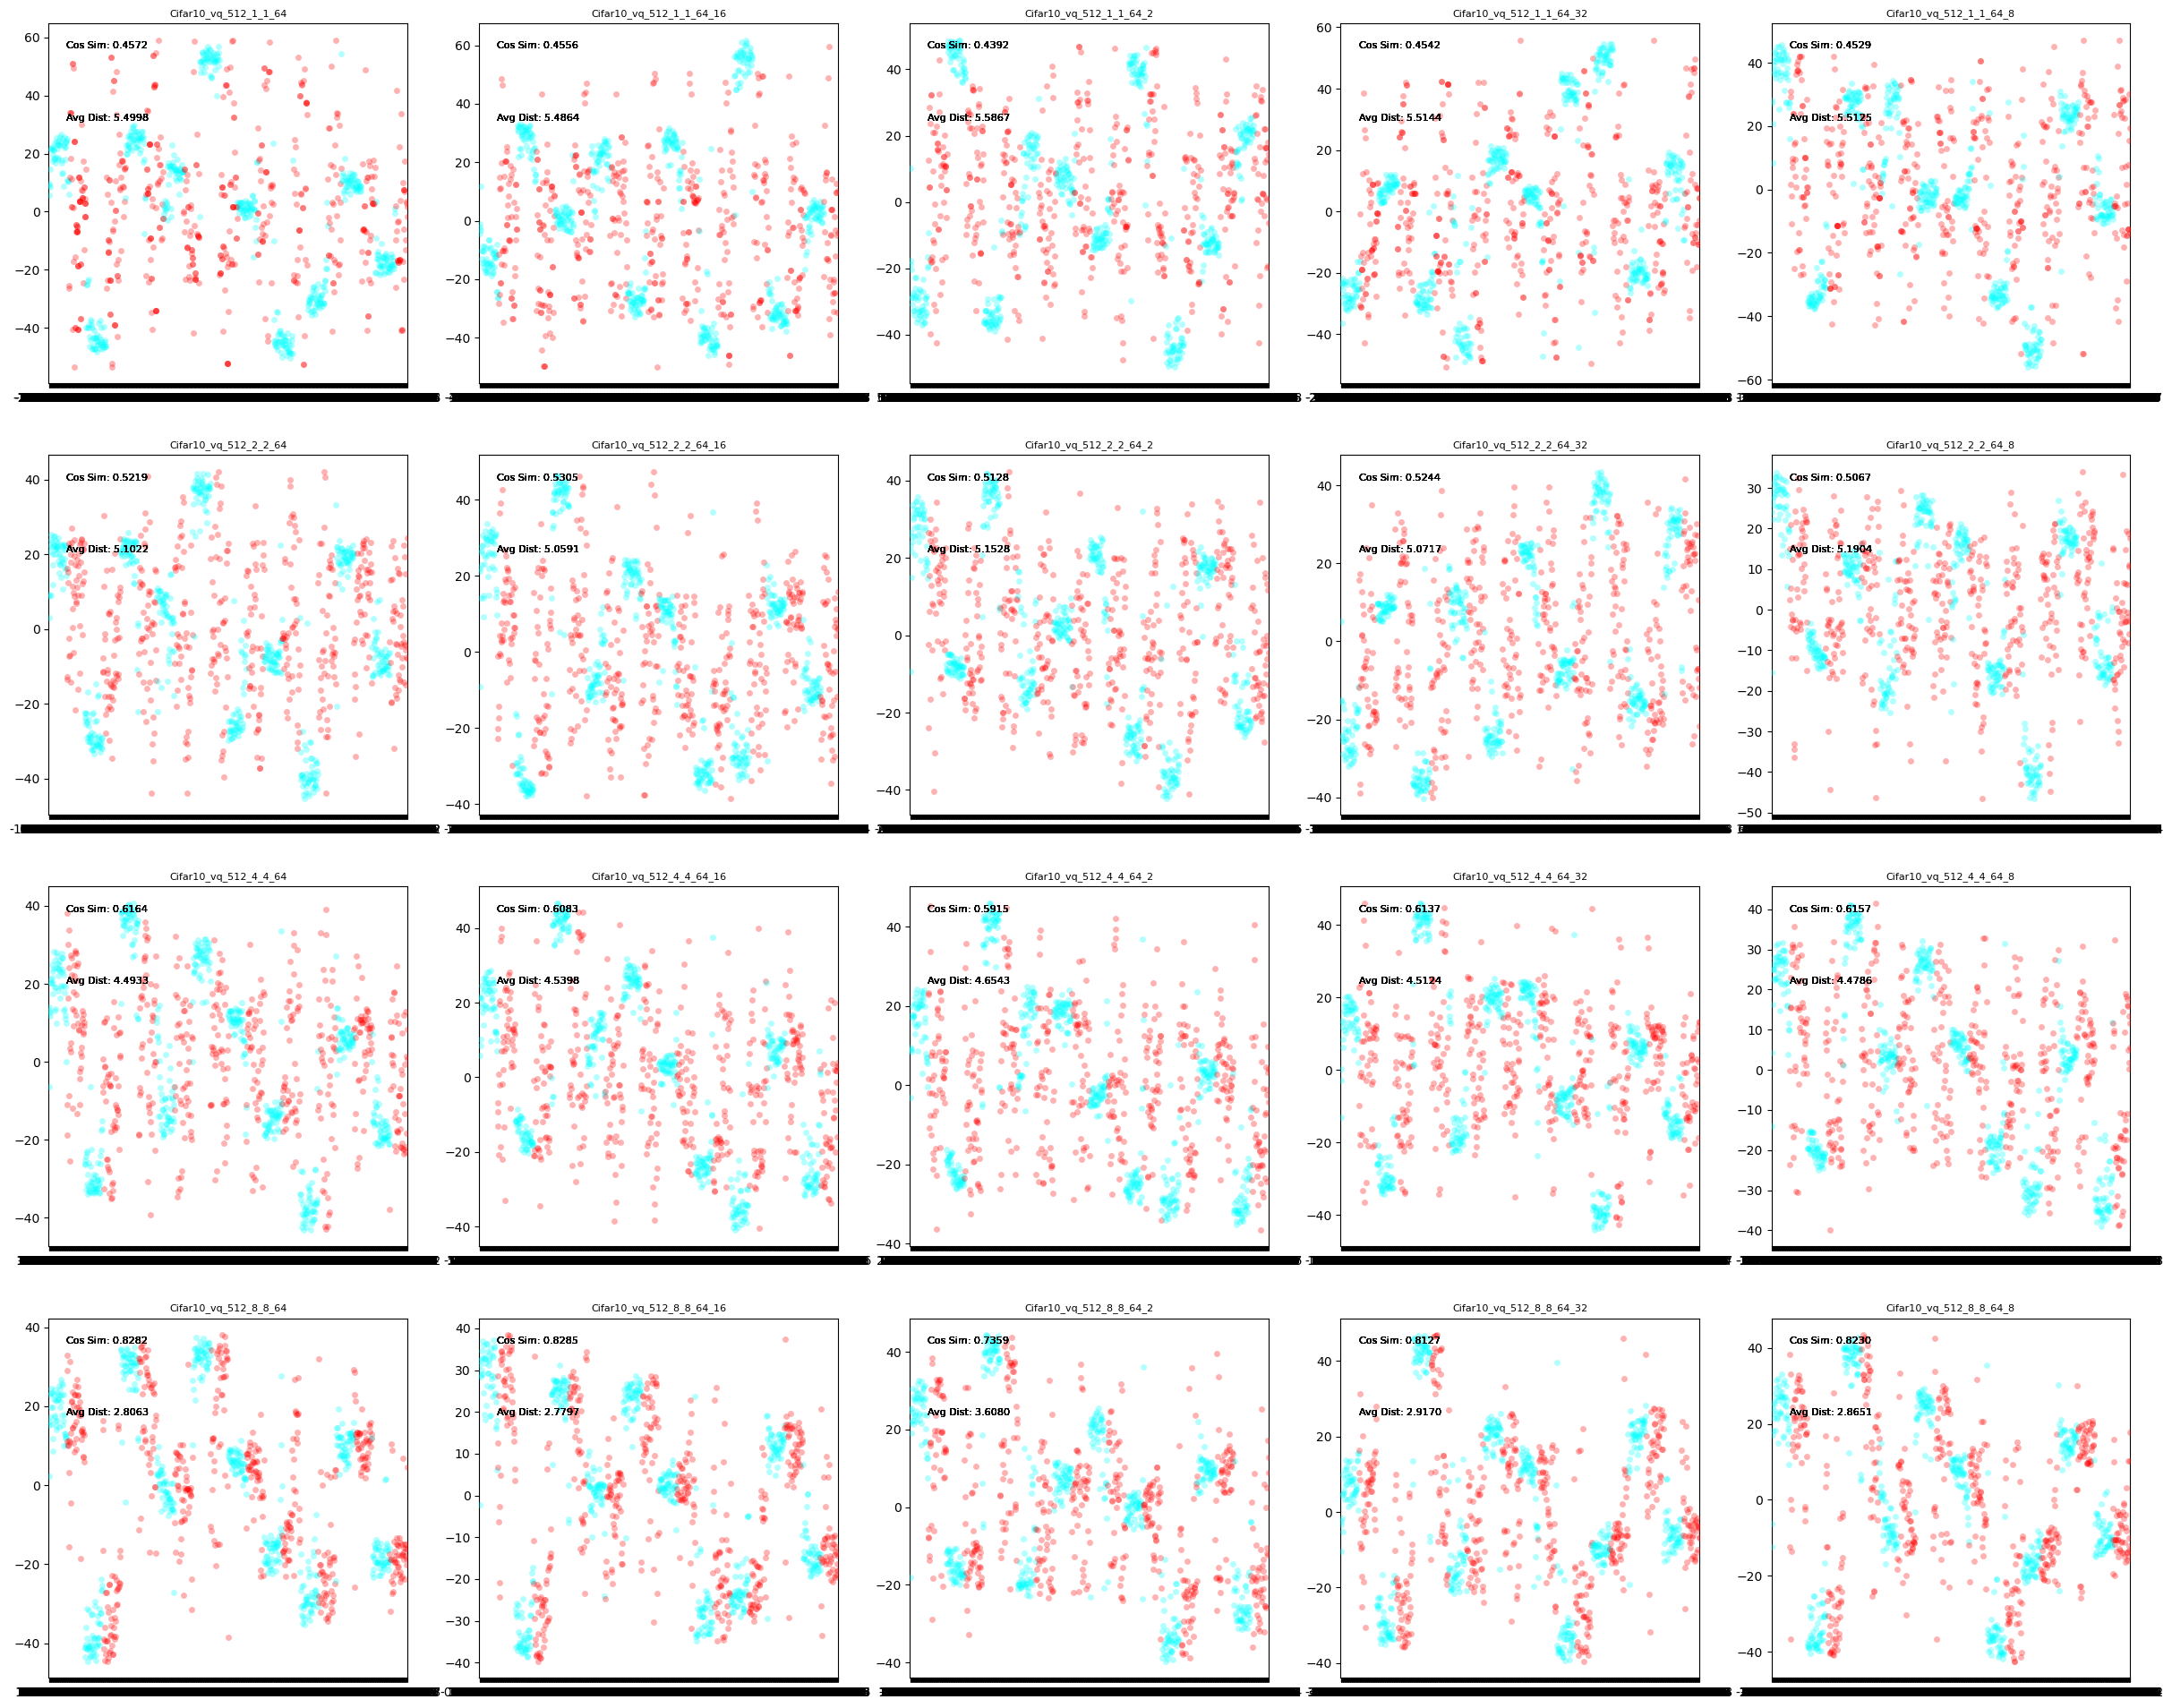

In [37]:
visualize_data_seperate(global_image_features)

subplots_H: 4, subplots_L: 5
20


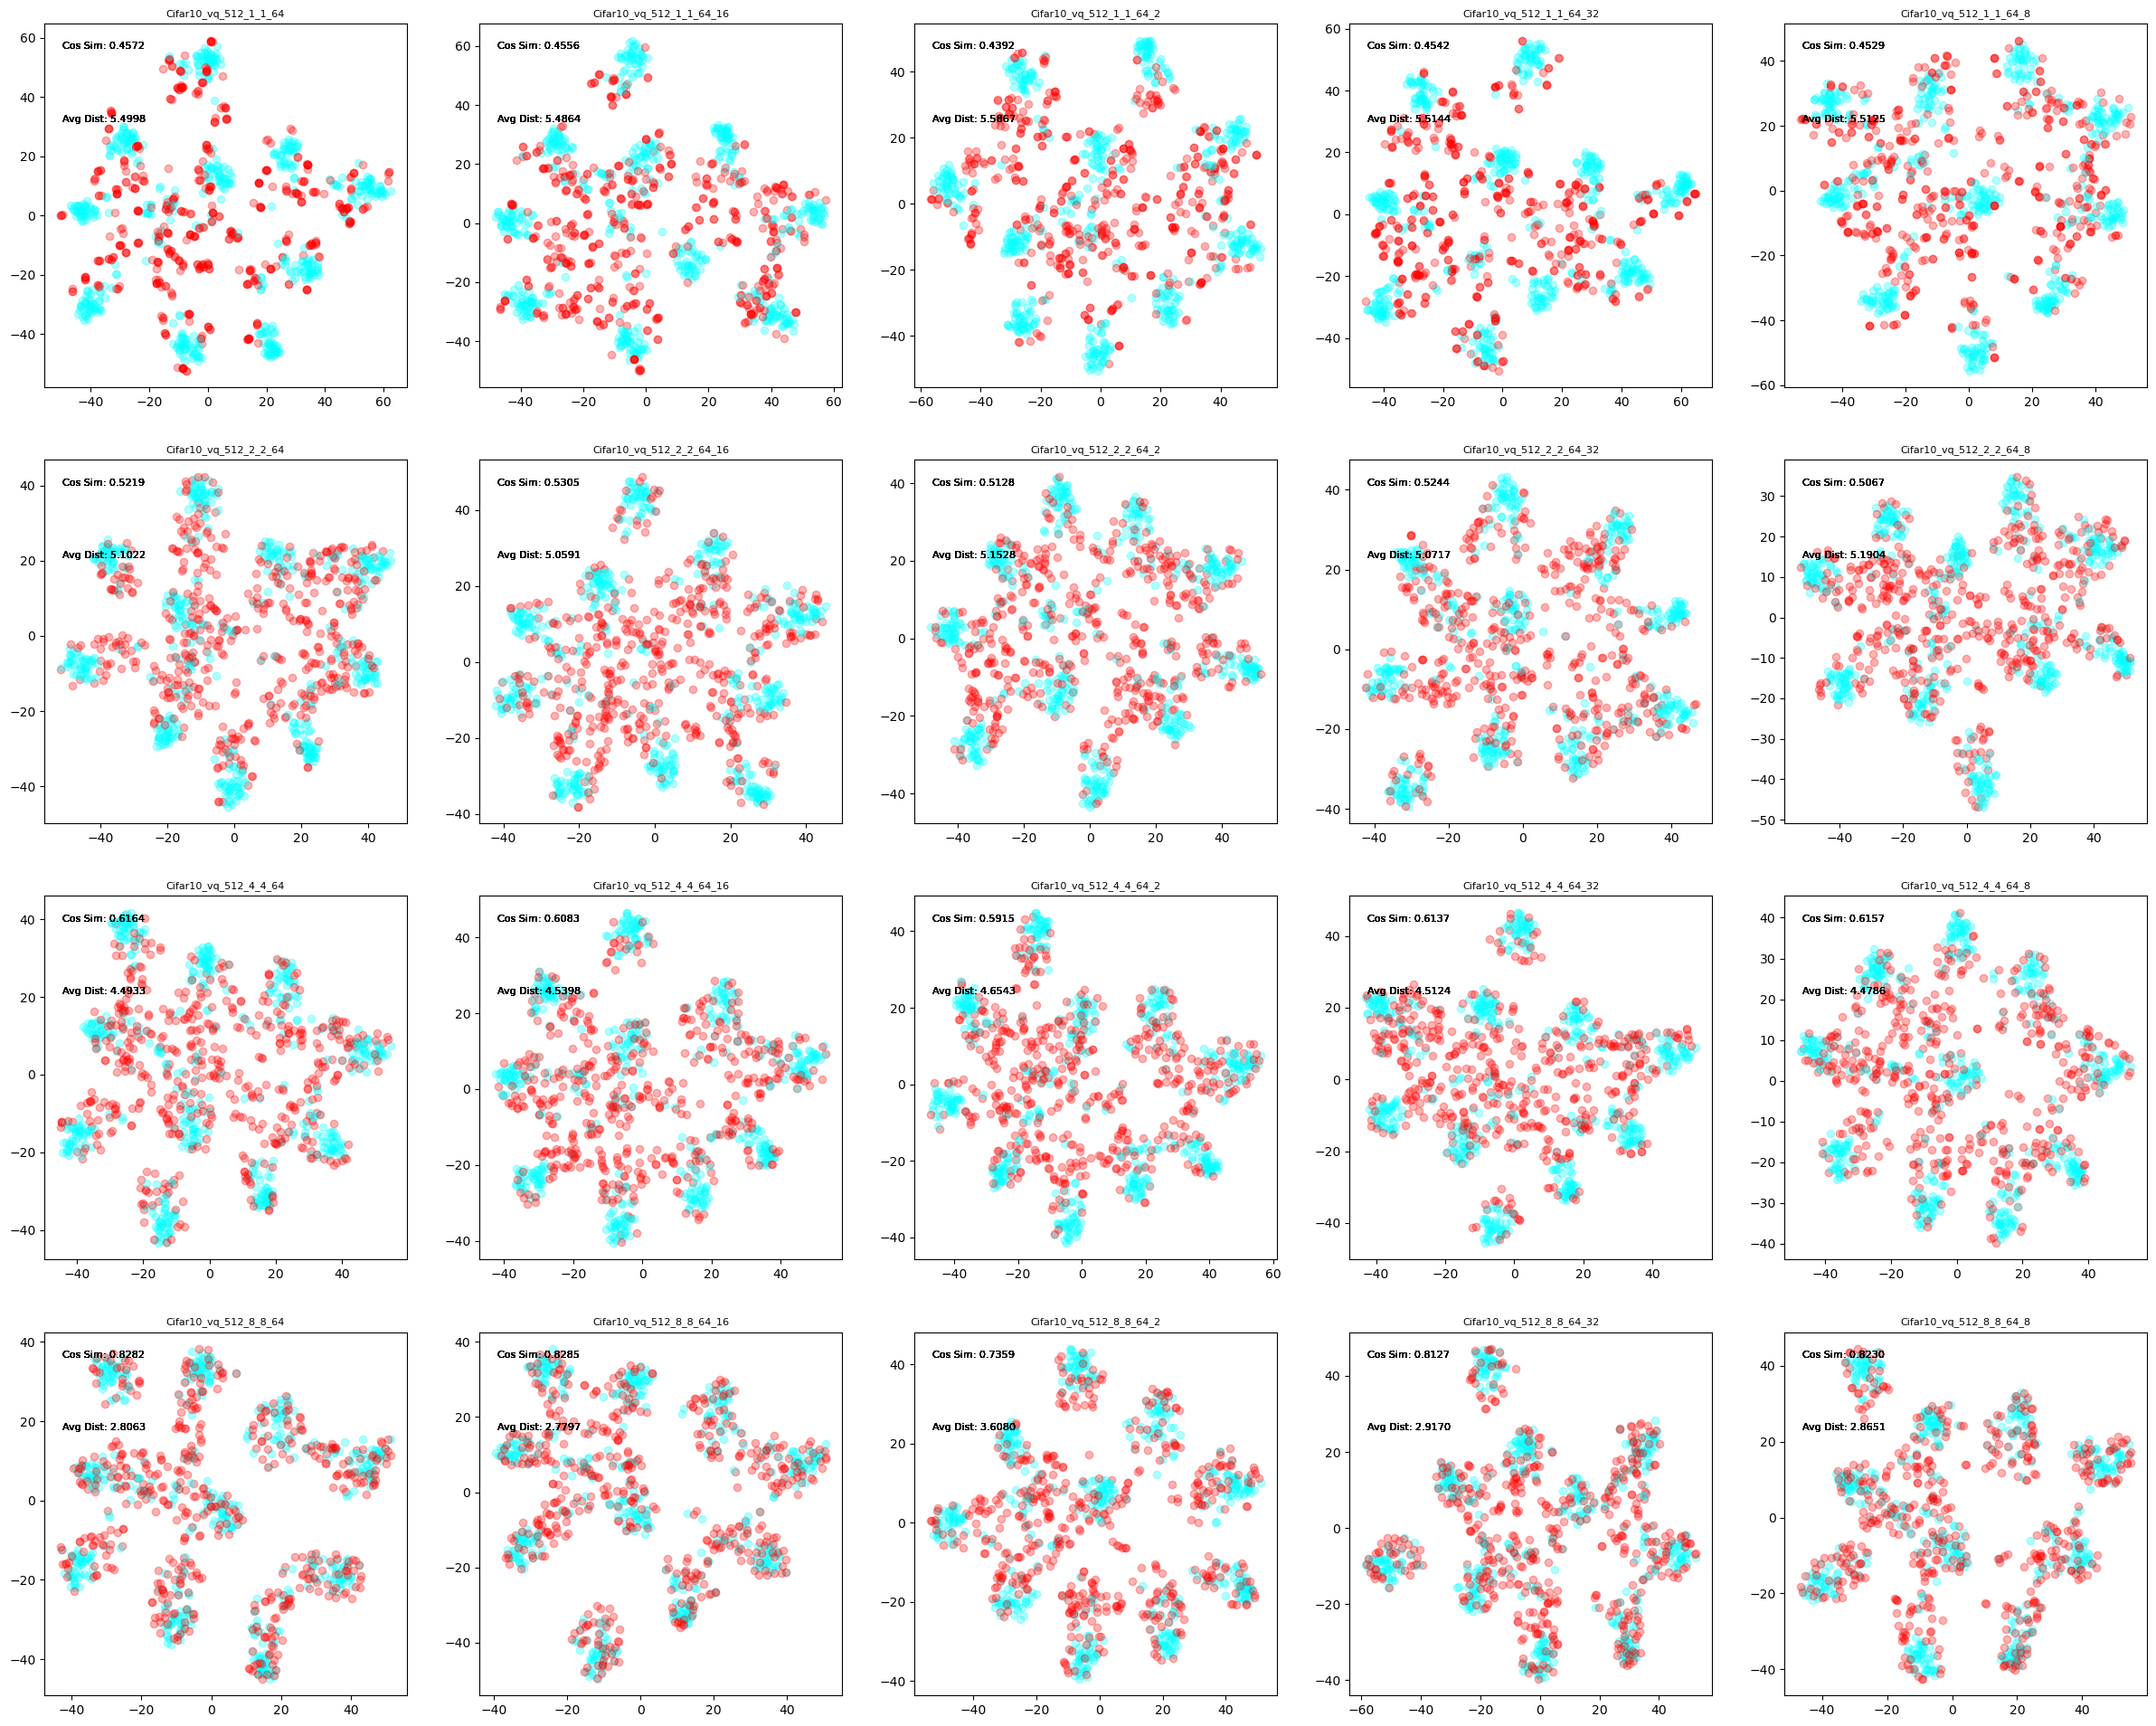

In [42]:
visualize_data_seperate(global_image_features) # scatter plot

begin to decompose the data 2d


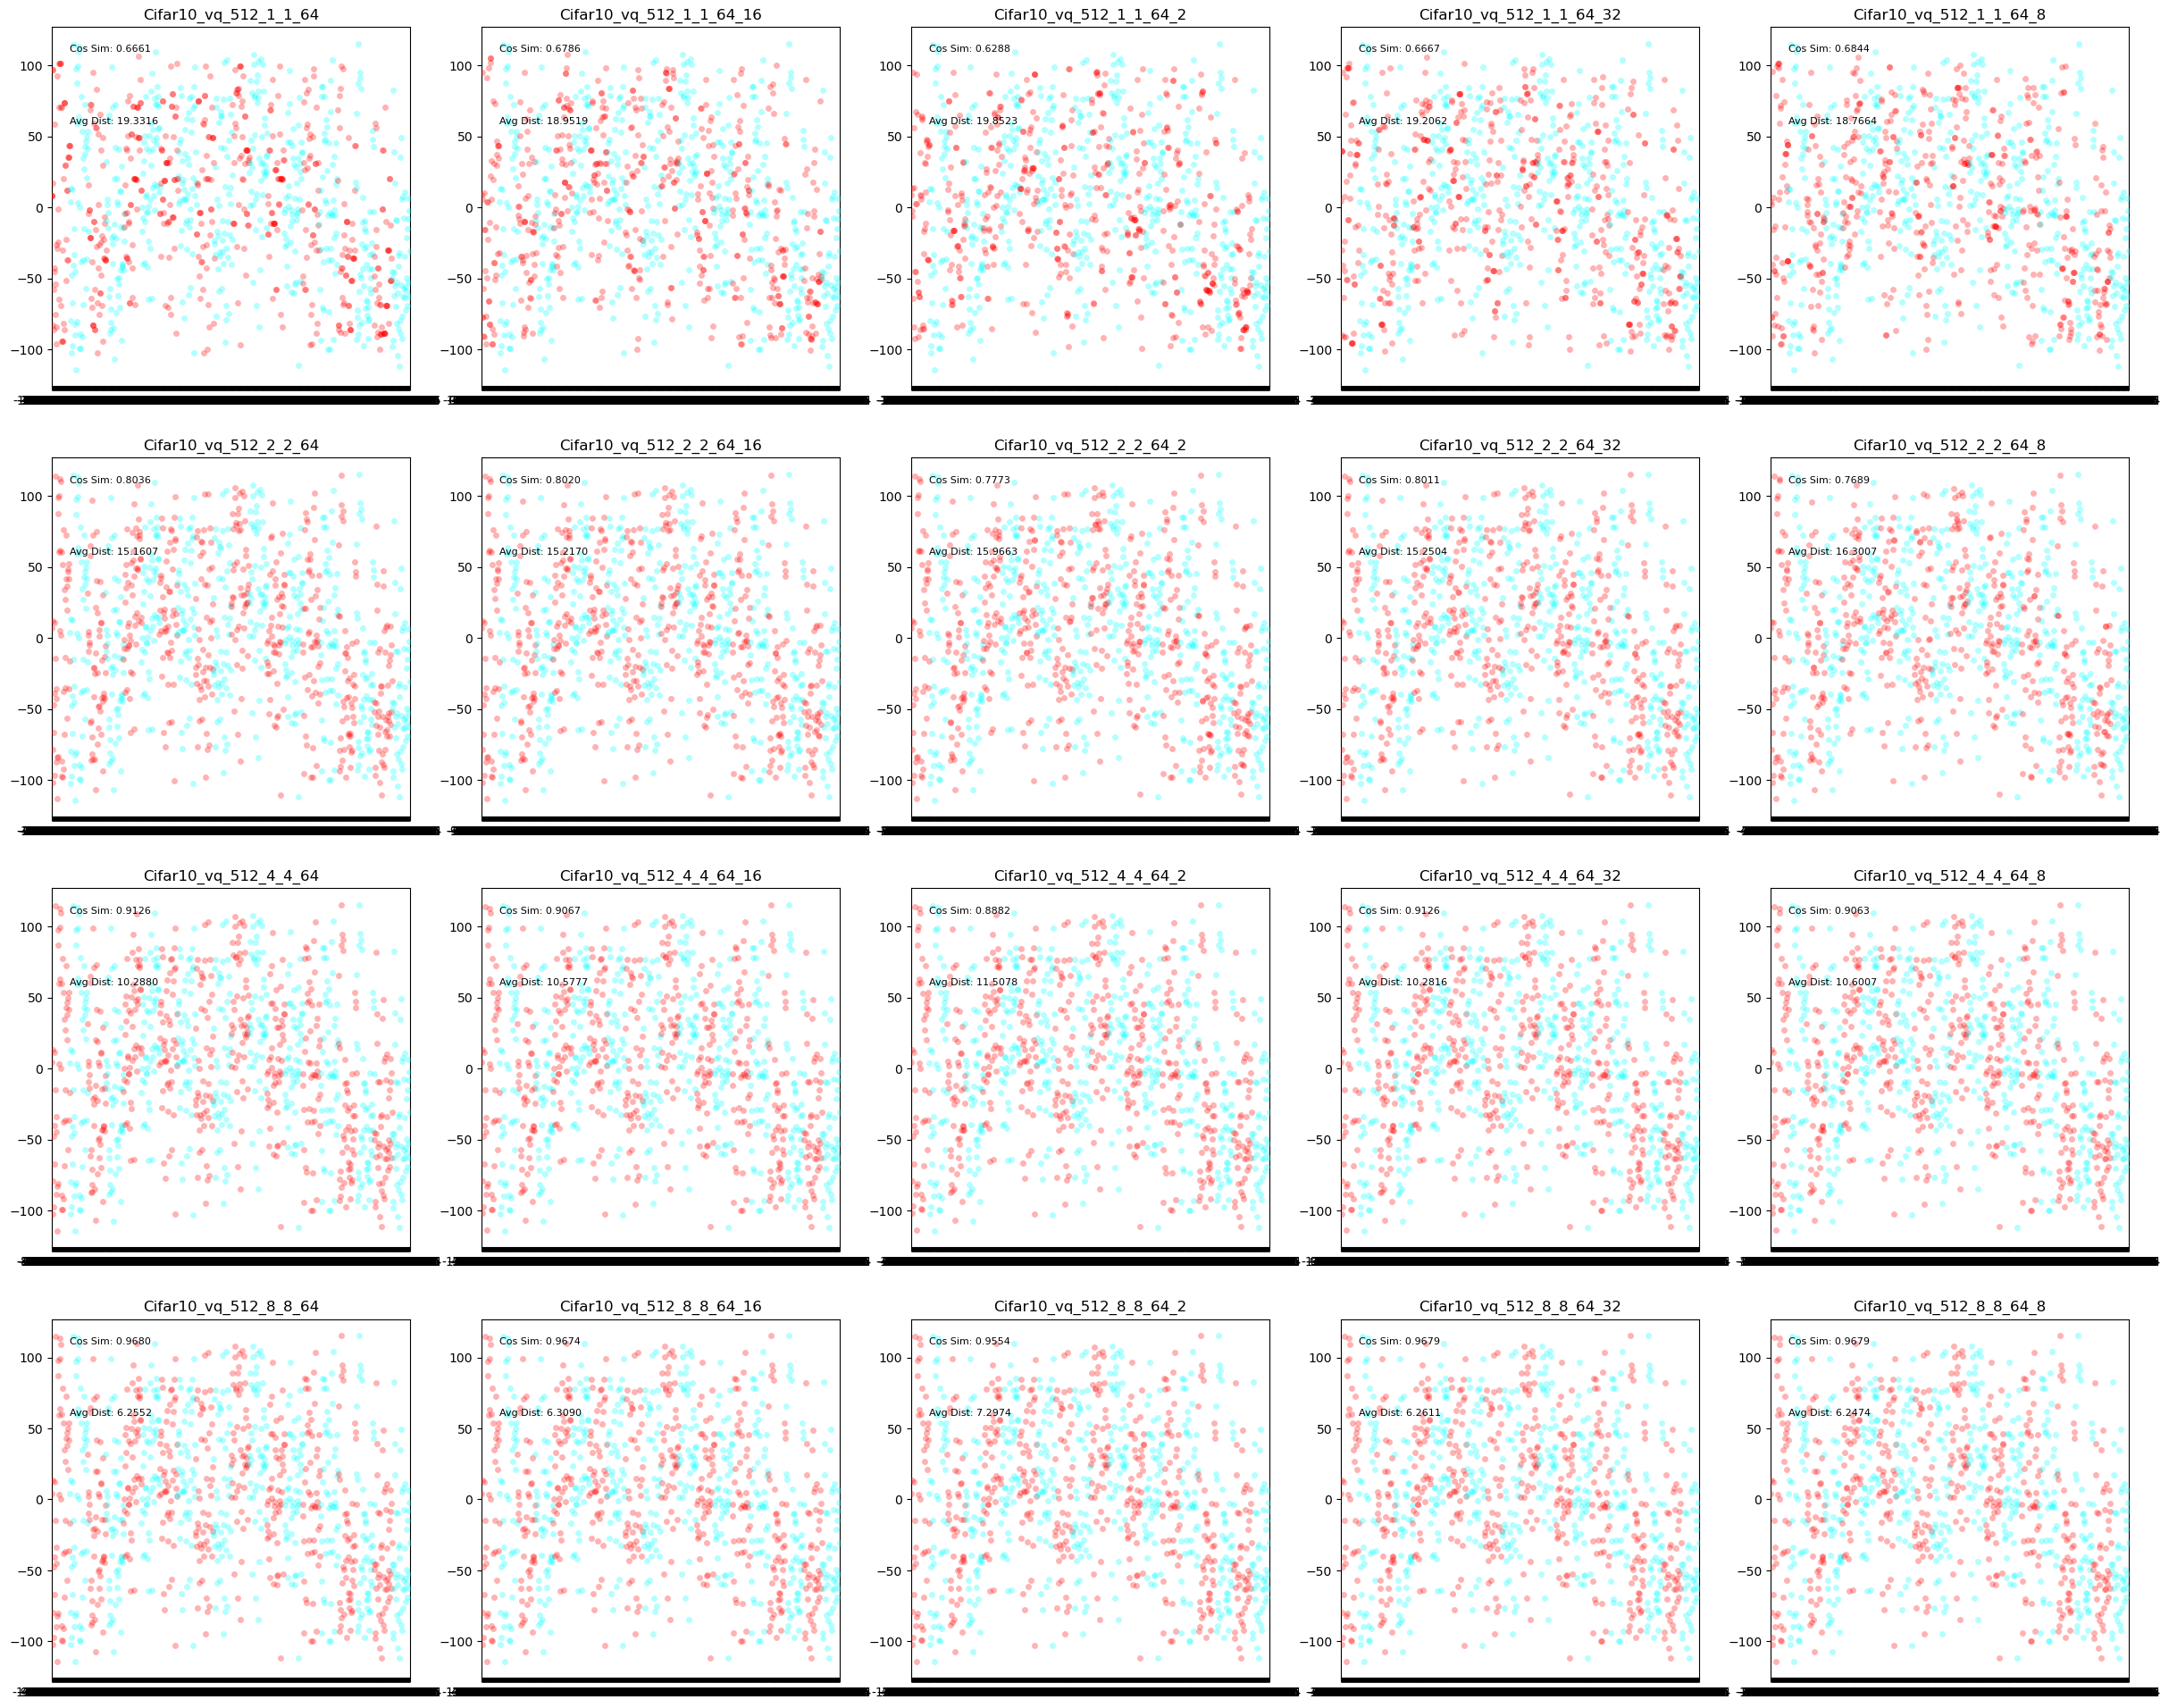

: 

In [49]:
visualize_data_direct_decompose(global_image_flattened)

begin to decompose the data 2d


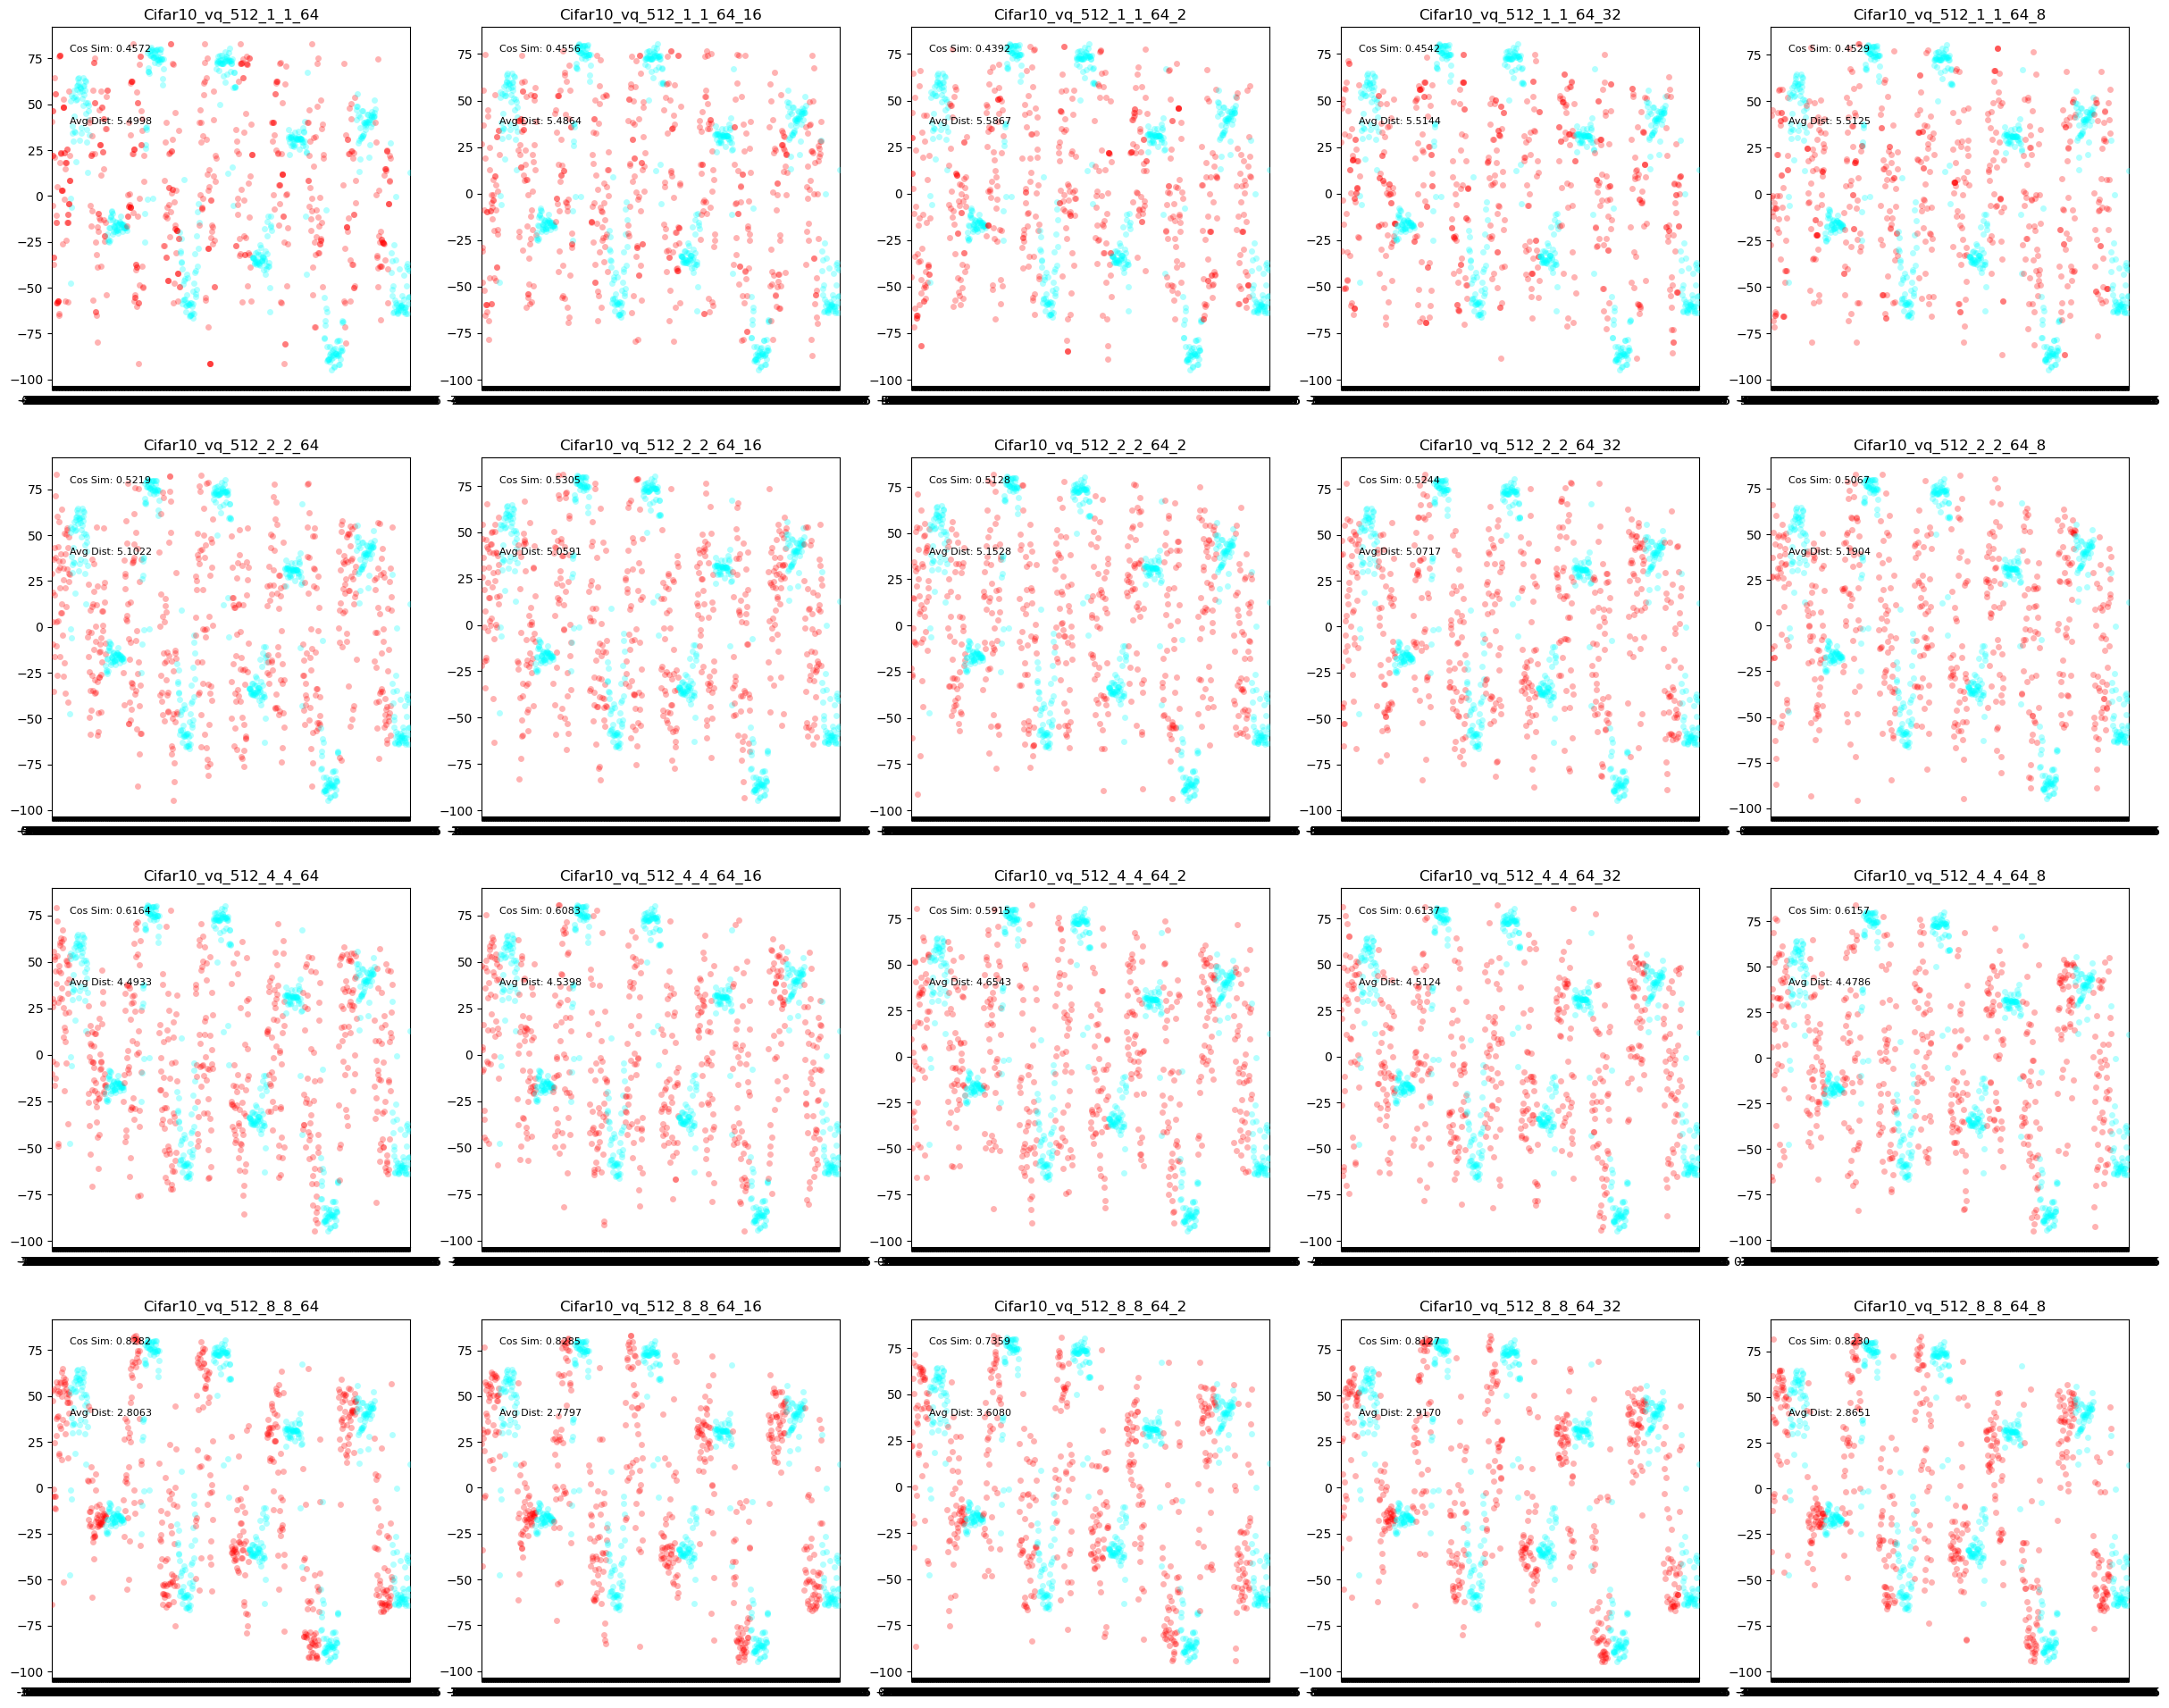

In [38]:
visualize_data_direct_decompose(global_image_features)

In [47]:
visualize_data_direct_decompose(global_image_flattened) # scatter plot

begin to decompose the data 2d


In [46]:
visualize_data_direct_decompose(global_image_features) # scatter plot

begin to decompose the data 2d
